# **MODERN COMPUTER VISION** #
##### BY RAJEEV RATAN

<h2 style="margin-bottom:0;">🚀 YOLOv3 in using cv2.dnn.readNetFrom()</h2>

<h5 style="margin-top:5px;">In this lesson we'll learn how to load a pre-trained YOLOV3 Model and use OpenCV to run inferences over a few images.</h5>

In [ ]:
# Our Setup, Import Libraries and Create our Imshow Function
import numpy as np
import cv2
import time
import os
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt

# Define our imshow function
def imshow(title = "Image", image = None, size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio, size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

!gdown --id 1rEV9xrrctxPwFPKvF3EC0sSNyYAZSEP4
!unzip -qq YOLO.zip

### **YOLO Object Detection** ##

In [4]:
# Load the COCO class labels our YOLO model was trained on
labelsPath = "../YOLO/yolo/coco.names"
LABELS = open(labelsPath).read().strip().split("\n")

# We now need to initialize a list of colors to represent each possible class label
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3), dtype="uint8")

print("Loading YOLO weights...")

weigfhtsPath = "../YOLO/yolo/yolov3.weights"
cfgPath = "../YOLO/yolo/yolov3.cfg"

# Create our blob object
net = cv2.dnn.readNetFromDarknet(cfgPath, weigfhtsPath)

# Set our backend
net.setPreferableBackend(cv2.dnn.DNN_BACKEND_OPENCV)

print("Our YOLO Layers")
ln = net.getLayerNames()

# There are 254 layers
print(len(ln), ln)

Loading YOLO weights...
Our YOLO Layers
254 ('conv_0', 'bn_0', 'leaky_1', 'conv_1', 'bn_1', 'leaky_2', 'conv_2', 'bn_2', 'leaky_3', 'conv_3', 'bn_3', 'leaky_4', 'shortcut_4', 'conv_5', 'bn_5', 'leaky_6', 'conv_6', 'bn_6', 'leaky_7', 'conv_7', 'bn_7', 'leaky_8', 'shortcut_8', 'conv_9', 'bn_9', 'leaky_10', 'conv_10', 'bn_10', 'leaky_11', 'shortcut_11', 'conv_12', 'bn_12', 'leaky_13', 'conv_13', 'bn_13', 'leaky_14', 'conv_14', 'bn_14', 'leaky_15', 'shortcut_15', 'conv_16', 'bn_16', 'leaky_17', 'conv_17', 'bn_17', 'leaky_18', 'shortcut_18', 'conv_19', 'bn_19', 'leaky_20', 'conv_20', 'bn_20', 'leaky_21', 'shortcut_21', 'conv_22', 'bn_22', 'leaky_23', 'conv_23', 'bn_23', 'leaky_24', 'shortcut_24', 'conv_25', 'bn_25', 'leaky_26', 'conv_26', 'bn_26', 'leaky_27', 'shortcut_27', 'conv_28', 'bn_28', 'leaky_29', 'conv_29', 'bn_29', 'leaky_30', 'shortcut_30', 'conv_31', 'bn_31', 'leaky_32', 'conv_32', 'bn_32', 'leaky_33', 'shortcut_33', 'conv_34', 'bn_34', 'leaky_35', 'conv_35', 'bn_35', 'leaky_36'

#####
The input to the network is called a blob object.
The function cv.dnn.blobFromImage(img, scale, size, mean) transforms the image into a blob.
blob = cv.dnn.blobFromImage(img, 1/255.0, (416, 416), swapRB=True, crop=False)

**It has the following parameters:**
1. the image to transform.
2. the scale factor (1/255 to scale the pixel values to [0...1])
3. the size, here a 416x416 square image.
4. the mean value (default=0).
5. the option swapBR=True (since OpenCV uses BGR)

**Note** A blob is a 4D numpy arrat object (images, channels, width, height). The image below shows the red channel of the blob. You notice the
brightness of the red jacket in the background.
#####


Starting Detections...


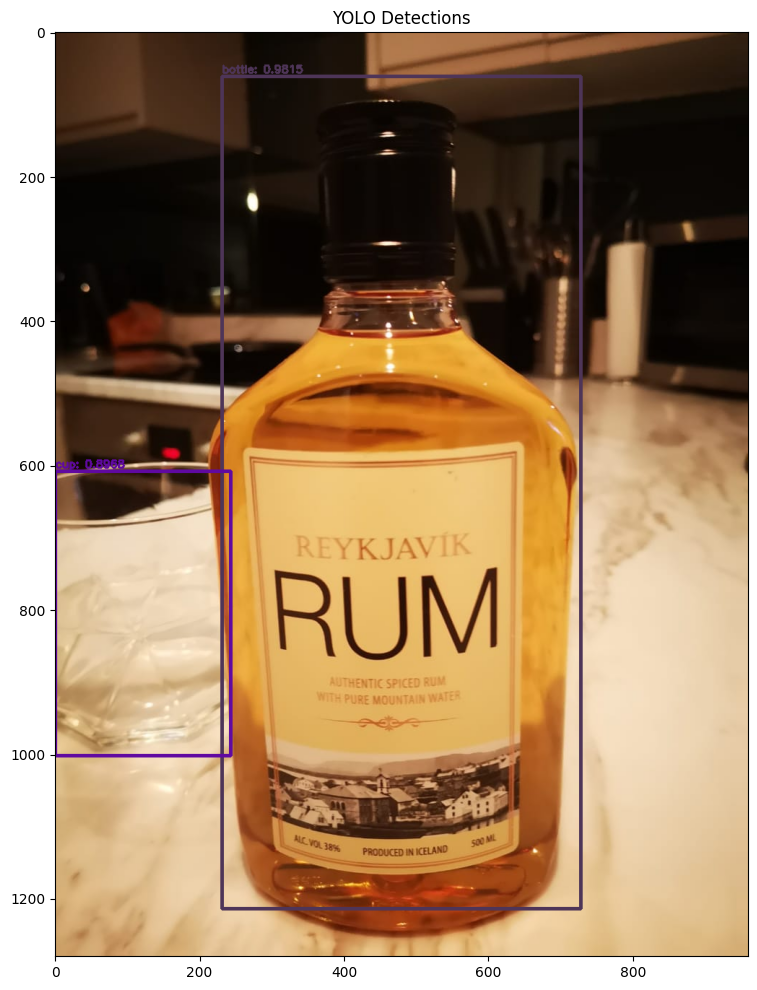

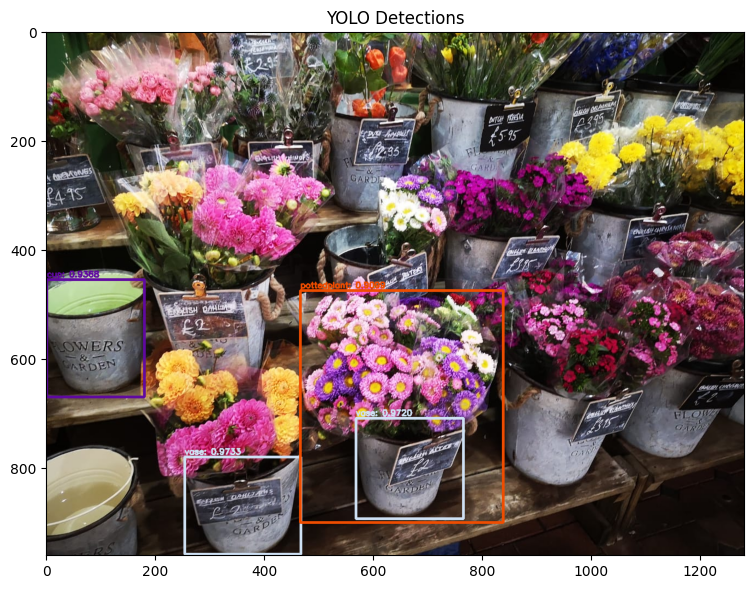

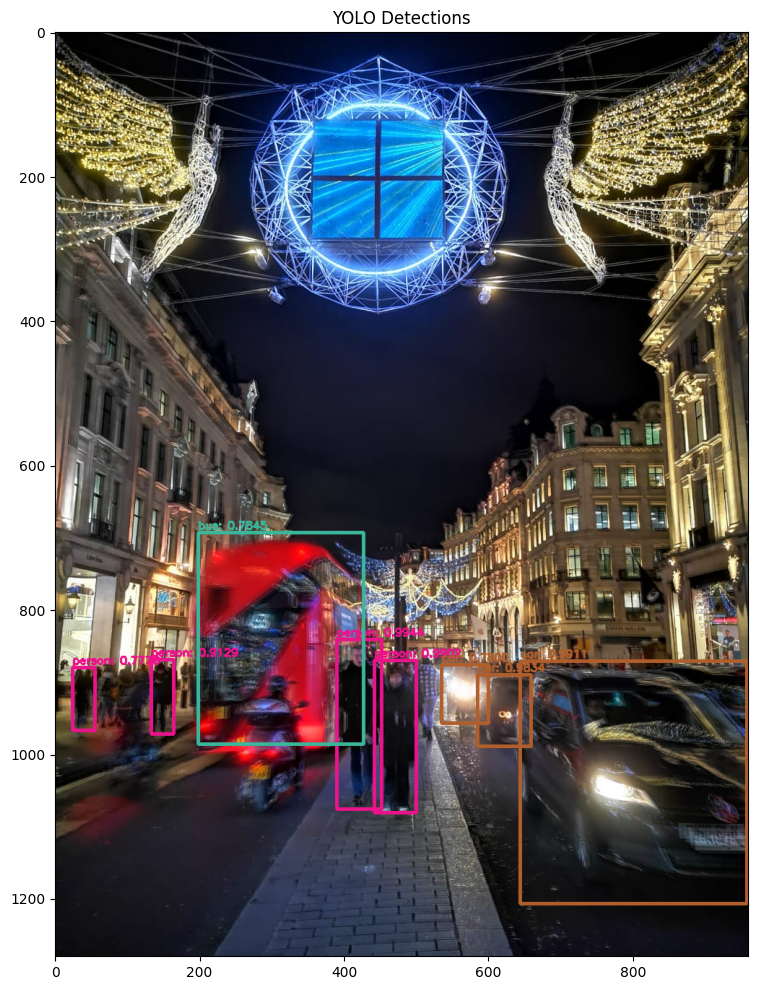

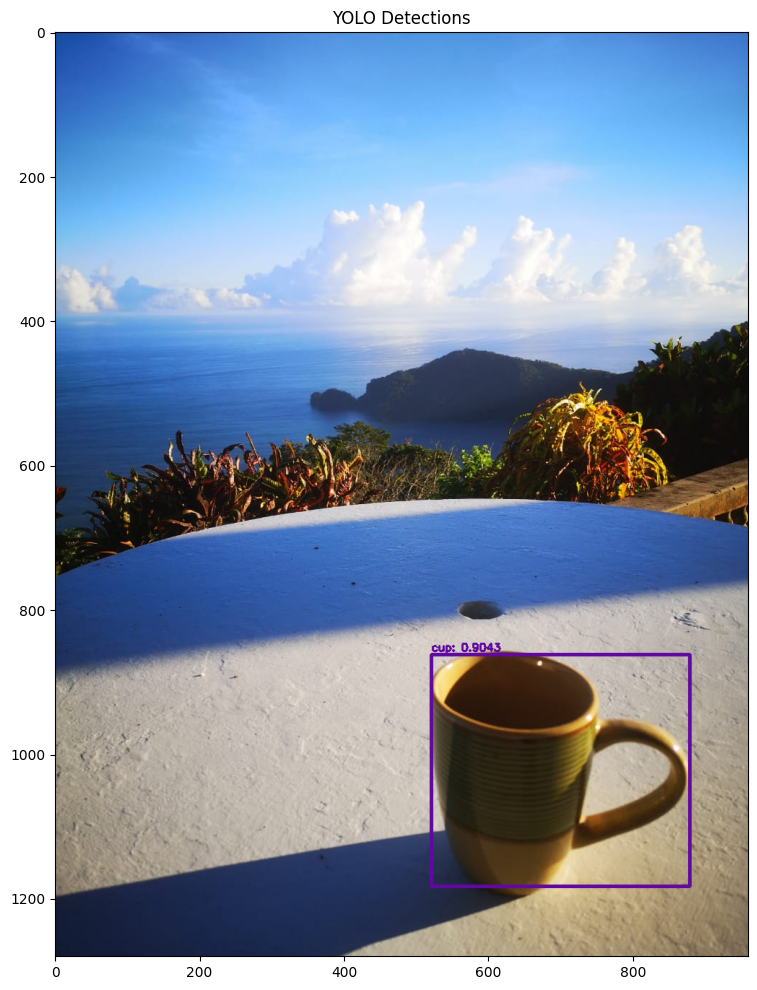

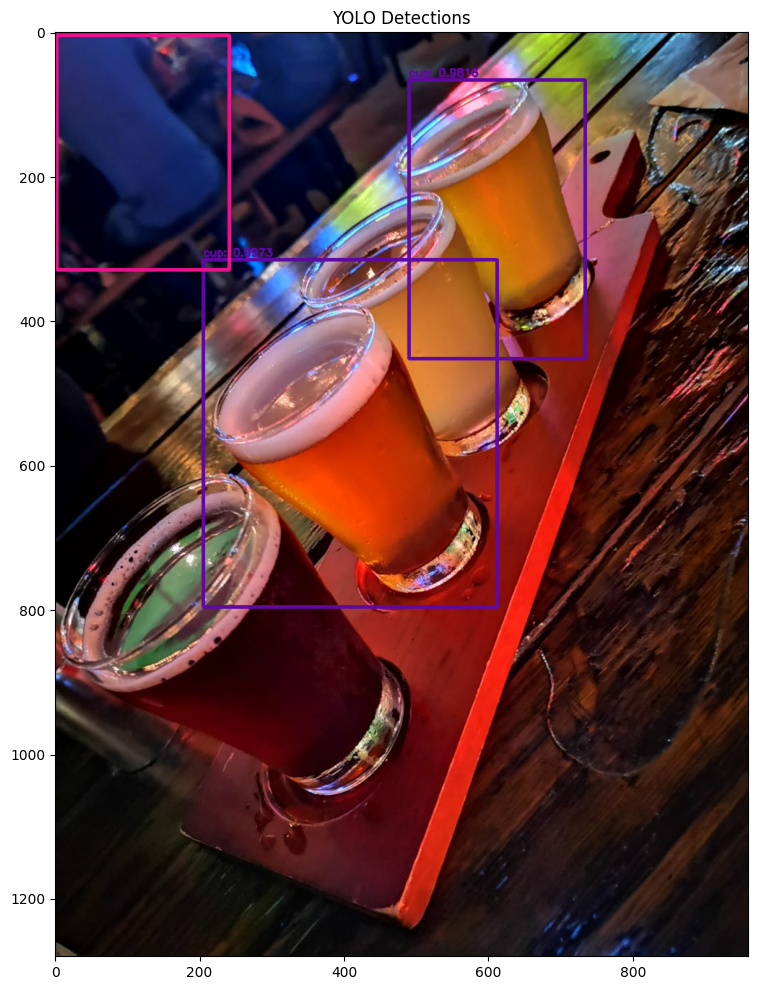

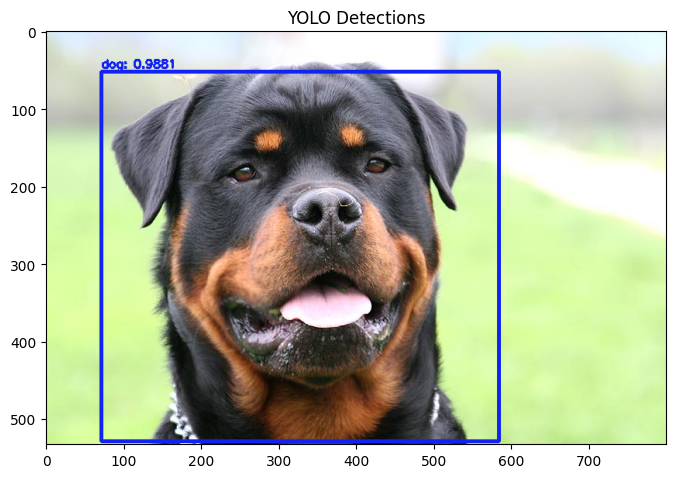

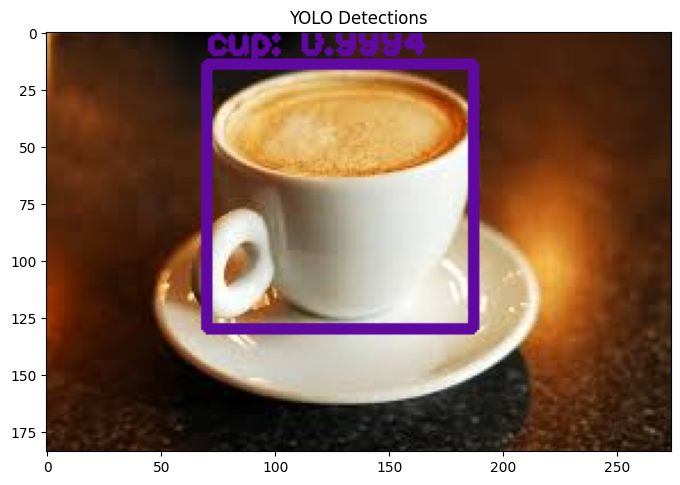

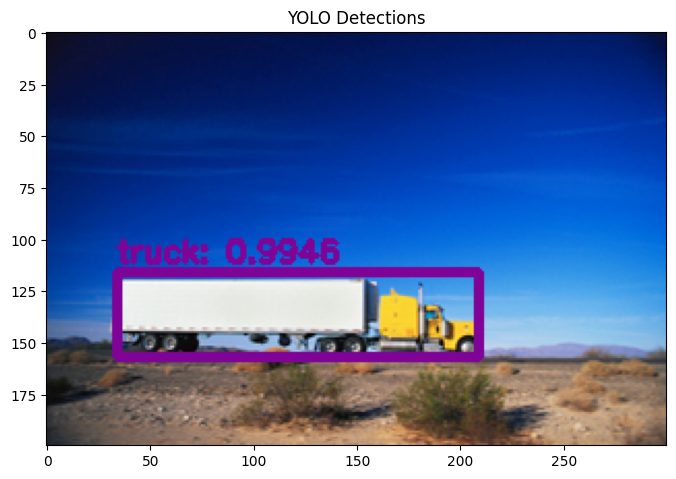

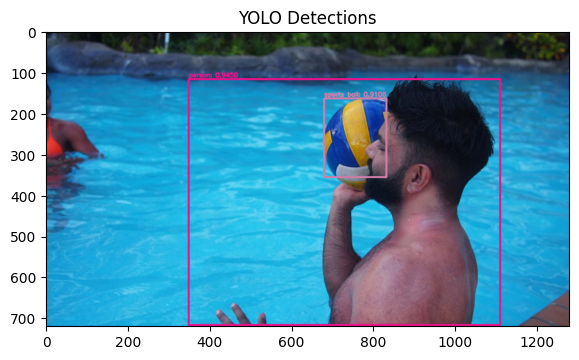

In [5]:
print("Starting Detections...")
# Get images located in ./images folder
mypath = "../YOLO/images"
file_names = [f for f in listdir(mypath) if isfile(join(mypath, f))]

# Loop through images run them through our classifier
for file in file_names:
    # load our input image and grab its spatial dimensions
    image = cv2.imread(join(mypath, file))
    (H, W) = image.shape[:2]

    # we want only the *output* layer names that we need from YOLO
    ln = net.getLayerNames()
    ln = [ln[i - 1] for i in net.getUnconnectedOutLayers()]

    # Now we construct our blob from our input image
    blob = cv2.dnn.blobFromImage(image, 1 / 255.0, (416, 416), swapRB=True, crop=False)
    # We set our input to our image blob
    net.setInput(blob)
    # Then we run a forward pass through the network
    layerOutputs = net.forward(ln)

    # we initialuze our lists of detected bounding boxes, confidences, and classes
    boxes = []
    confidences = []
    IDs = []

    # Loop over each of the layer outputs
    for output in layerOutputs:

        # Loop over each detections
        for detection in output:
            # obtain class ID and probability of detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]

            # We keep only the most probably predictions
            if confidence > 0.75:
                # We scale the bounding box coordinates relative to the image
                # Note: YOLO actually returns the center (x, y) of the bounding 
                # box followed by the width and height of the box
                box = detection[0:4] * np.array([W, H, W, H])
                (centerX, centerY, width, height) = box.astype("int")

                # Use the top and left corner of the bounding box
                # Remember we already have the width and height
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))

                # Append our list of bounding box coordinates, confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                IDs.append(classID)
    
    # Now we apply non-maxima suppression to suppress weak, overlapping bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, 0.5, 0.3)

    # We proceed once a detection has been found
    if len(idxs) > 0:
        # Loop over the indexes we are keeping
        for i in idxs.flatten():
            # Get the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])

            # Draw a bounding box rectangle and label on the image
            color = [int(c) for c in COLORS[IDs[i]]]
            cv2.rectangle(image, (x, y), (x + w, y + h), color, 3)
            text = "{}: {:.4f}".format(LABELS[IDs[i]], confidences[i])
            cv2.putText(image, text, (x, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Show the output image
    imshow("YOLO Detections", image, size = 12)

### **Note: How to Perform non maximum suppression given boxes and corresponding scores.** ###
##### 
indices = cv.dnn.NMSBoxes ( bboxes, scores, score_threshold, nms_threshold[, eta[, top_k]])

**Parameters**
1. bboxes: a set of bounding boxes to apply NMS.
2. scores: a set of corresponding confidences.
3. score_threshold: a threshold to filter boxes by score.
4. nms_threshold: a threshold used in non maximum supression. Indices: the kept indices of bboxes after NMS.
5. eta: a coefficient in adaptive threshold formula: nms_threshold+1 = eta.nms_thresholdi.
6. top_k: if > 0, keep at most top k picked indices.
#####